In [ ]:
from transformers import (
    RobertaTokenizer, RobertaModel, RobertaForSequenceClassification,
    T5EncoderModel, T5Tokenizer,
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    Trainer, TrainingArguments
)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from datetime import datetime
import warnings
import joblib
import io
from google.colab import files, drive
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as XGBClassifier
from imblearn.over_sampling import SMOTE
from IPython.display import display, HTML
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive for saving results
drive.mount('/content/drive')

# Create a directory for saving results
!mkdir -p '/content/drive/MyDrive/code_review_analysis1'
SAVE_DIR = '/content/drive/MyDrive/code_review_analysis1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set(style='whitegrid')

# Define a helper function for section headings
def print_section(title):
    """Print a formatted section heading"""
    print(f"\n{'='*80}")
    print(f"  {title}")
    print(f"{'='*80}\n")

# SECTION 1: DATA LOADING AND INITIAL EXPLORATION


In [ ]:
print_section("SECTION 1: DATA LOADING AND INITIAL EXPLORATION")
# Load the dataset from a specified path

try:
    df = pd.read_csv('/content/results_analytics.csv')
    print("Dataset loaded successfully from /content/results_analytics.csv")
except FileNotFoundError:
    print("Error: /content/results_analytics.csv not found. Please ensure the file is uploaded or correctly placed.")

# Display basic information about the dataset
print("\n📊 Dataset Overview:")
print(f"- Number of rows: {df.shape[0]}")
print(f"- Number of columns: {df.shape[1]}")

# Display column information
print("\n🔍 Column Details:")
print(df.dtypes)

# Display the first few rows
print("\n🔎 First 5 Rows:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\n🔍 Missing Values:")
print(missing_values)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Number of duplicate rows: {duplicates}")

# Get basic statistics
print("\n📈 Numerical Column Statistics:")
display(df.describe())


  SECTION 1: DATA LOADING AND INITIAL EXPLORATION

Dataset loaded successfully from /content/results_analytics.csv

📊 Dataset Overview:
- Number of rows: 96
- Number of columns: 11

🔍 Column Details:
code                  object
language              object
quality_score        float64
has_bugs                bool
complexity            object
timestamp             object
review_status         object
has_bugs_num           int64
complexity_high        int64
complexity_low         int64
complexity_medium      int64
dtype: object

🔎 First 5 Rows:


,code,language,quality_score,has_bugs,complexity,timestamp,review_status,has_bugs_num,complexity_high,complexity_low,complexity_medium
0,#include <stdio.h>\n#include <stdlib.h>\nint* ...,c,81.10,False,medium,2025-05-21T07:54:43.853971,approved,1,0,0,1
1,"function debounce(func, delay) {\n let time...",javascript,85.29,False,medium,2025-05-21T07:54:43.854043,approved,0,0,0,1
2,public class BankAccount {\n private double...,java,89.41,False,medium,2025-05-21T07:54:43.854026,approved,0,0,0,1
3,async function fetchUserData(userId) {\n tr...,javascript,79.60,False,high,2025-05-21T07:54:43.854010,approved,0,1,0,0
4,int arr[2];\narr[2] = 5;,c,76.39,True,medium,2025-05-21T07:52:45.326381,pending,1,0,0,1



🔍 Missing Values:
code                 0
language             0
quality_score        0
has_bugs             0
complexity           0
timestamp            0
review_status        0
has_bugs_num         0
complexity_high      0
complexity_low       0
complexity_medium    0
dtype: int64

🔍 Number of duplicate rows: 0

📈 Numerical Column Statistics:


,quality_score,has_bugs_num,complexity_high,complexity_low,complexity_medium
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,81.836146,0.500000,0.510417,0.052083,0.437500
std,4.030205,0.502625,0.502516,0.223361,0.498682
min,74.160000,0.000000,0.000000,0.000000,0.000000
25%,79.240000,0.000000,0.000000,0.000000,0.000000
50%,81.495000,0.500000,1.000000,0.000000,0.000000
75%,84.087500,1.000000,1.000000,0.000000,1.000000
max,95.000000,1.000000,1.000000,1.000000,1.000000



📊 Categorical Column Distributions:


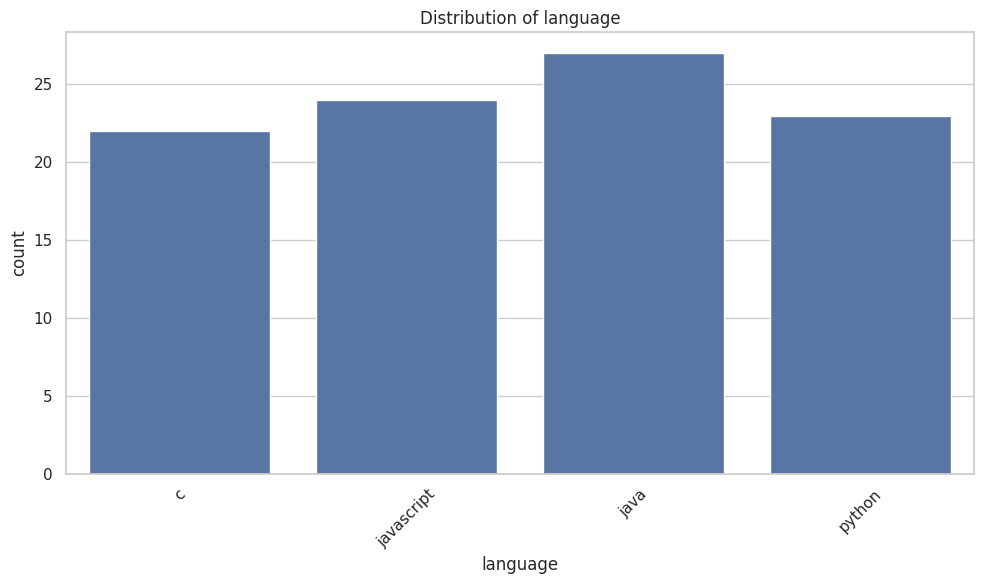


language distribution:
- java: 27 (28.12%)
- javascript: 24 (25.00%)
- python: 23 (23.96%)
- c: 22 (22.92%)


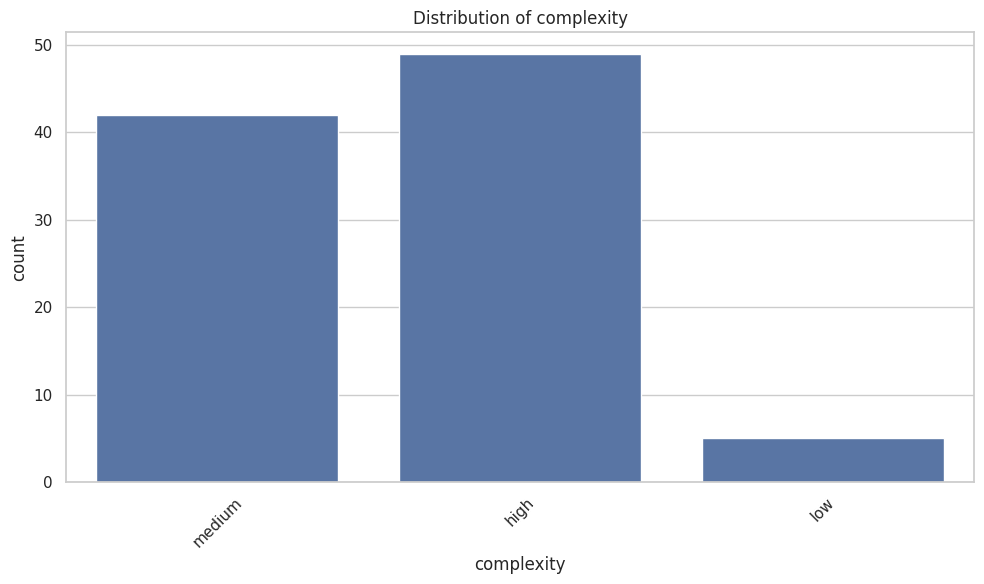


complexity distribution:
- high: 49 (51.04%)
- medium: 42 (43.75%)
- low: 5 (5.21%)


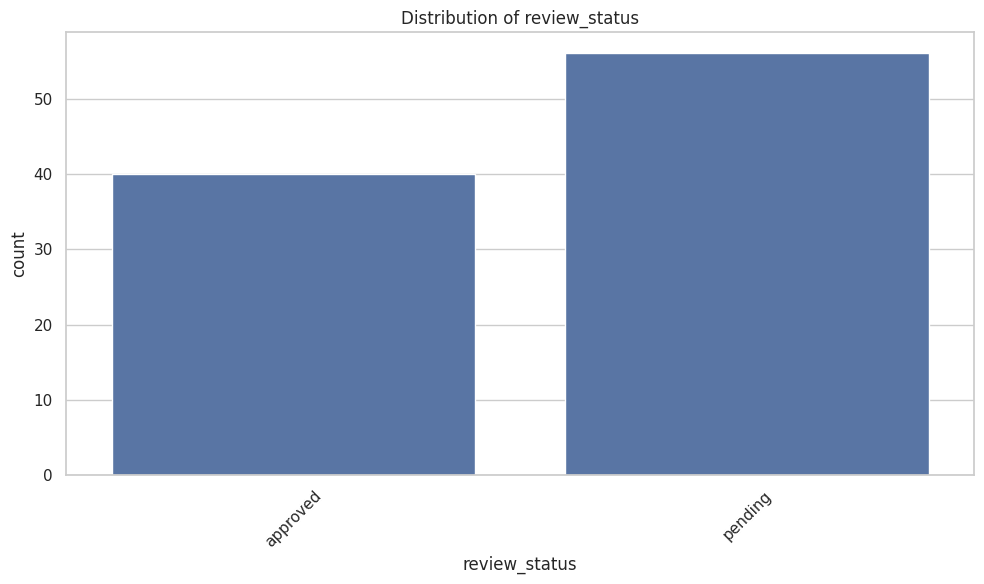


review_status distribution:
- pending: 56 (58.33%)
- approved: 40 (41.67%)


In [ ]:
# Display distribution of categorical columns
print("\n📊 Categorical Column Distributions:")
for col in ['language', 'complexity', 'review_status']:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print counts and percentages
        counts = df[col].value_counts()
        percentages = df[col].value_counts(normalize=True) * 100
        print(f"\n{col} distribution:")
        for idx, (count, percentage) in enumerate(zip(counts, percentages)):
            print(f"- {counts.index[idx]}: {count} ({percentage:.2f}%)")

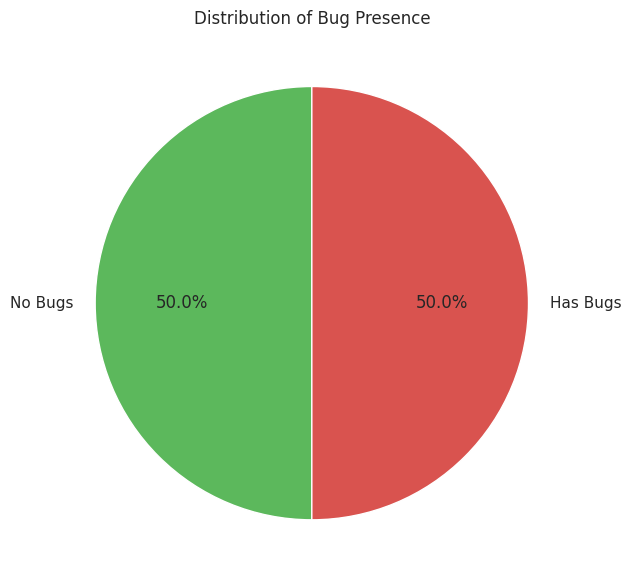


Target variable distribution:
- No Bugs: 48 (50.00%)
- Has Bugs: 48 (50.00%)


In [ ]:
# Display target variable distribution
if 'has_bugs' in df.columns:
    plt.figure(figsize=(8, 6))
    bug_counts = df['has_bugs'].value_counts()
    plt.pie(bug_counts, labels=['No Bugs', 'Has Bugs'] if bug_counts.index[0] == False else ['Has Bugs', 'No Bugs'],
            autopct='%1.1f%%', startangle=90, colors=['#5cb85c', '#d9534f'] if bug_counts.index[0] == False else ['#d9534f', '#5cb85c'])
    plt.title('Distribution of Bug Presence')
    plt.tight_layout()
    plt.show()

    # Print counts and percentages
    print("\nTarget variable distribution:")
    for idx, (count, percentage) in enumerate(zip(bug_counts, bug_counts / len(df) * 100)):
        label = 'No Bugs' if bug_counts.index[idx] == False else 'Has Bugs'
        print(f"- {label}: {count} ({percentage:.2f}%)")

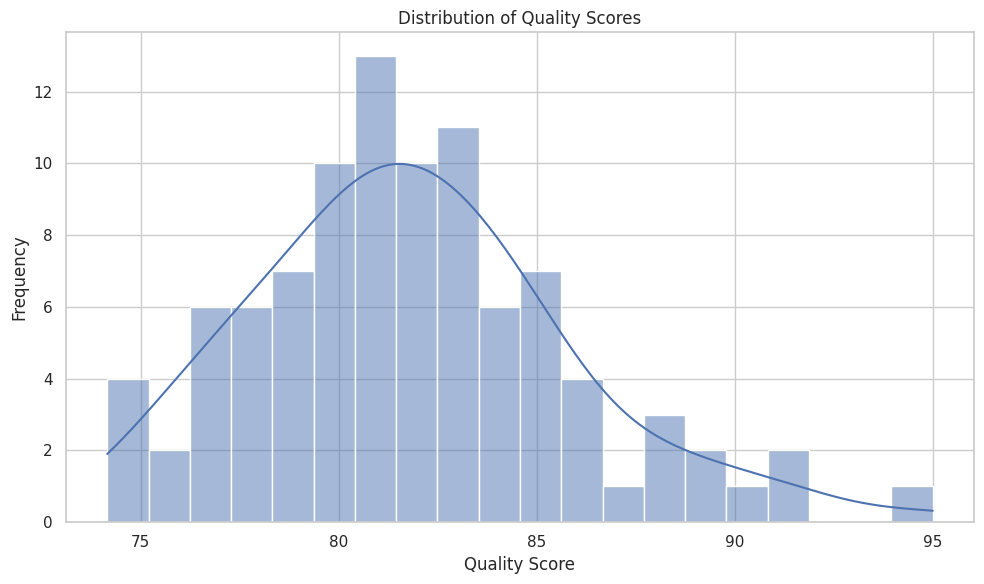

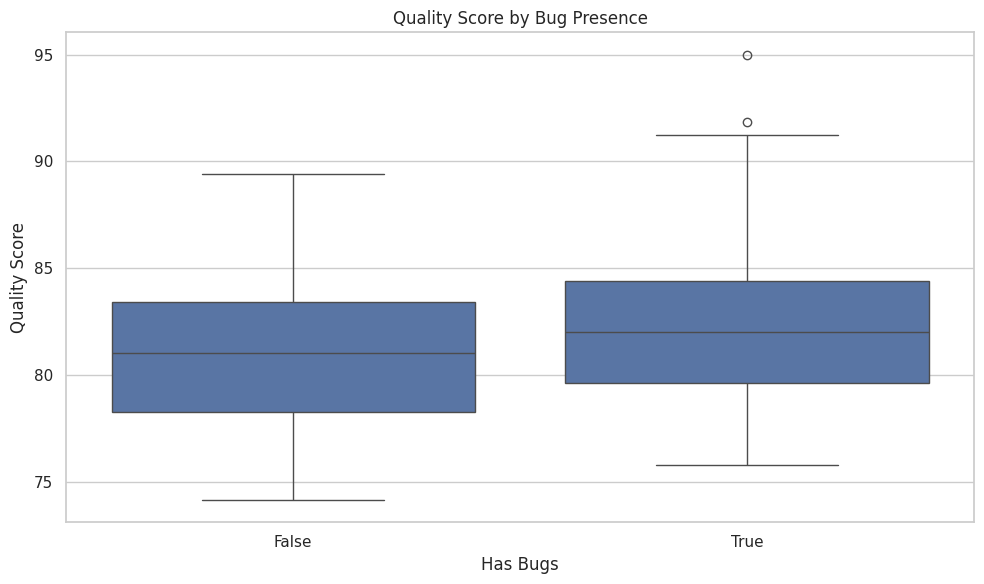

In [ ]:
# Check the distribution of quality scores
if 'quality_score' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['quality_score'], bins=20, kde=True)
    plt.title('Distribution of Quality Scores')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Display quality score by bug presence
    if 'has_bugs' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='has_bugs', y='quality_score', data=df)
        plt.title('Quality Score by Bug Presence')
        plt.xlabel('Has Bugs')
        plt.ylabel('Quality Score')
        plt.tight_layout()
        plt.show()

# SECTION 2: FEATURE ENGINEERING


In [ ]:
print_section("SECTION 2: FEATURE ENGINEERING")

# Function to extract features from code text
def extract_code_features(code_text):
    """Extract meaningful features from code text"""
    if pd.isna(code_text) or not isinstance(code_text, str):
        return {
            'code_length': 0,
            'line_count': 0,
            'function_count': 0,
            'class_count': 0,
            'loop_count': 0,
            'condition_count': 0,
            'comment_count': 0,
            'variable_count': 0,
            'whitespace_ratio': 0,
            'max_line_length': 0,
            'avg_line_length': 0,
            'max_indentation_depth': 0
        }

    # Basic metrics
    code_length = len(code_text)
    lines = code_text.split('\n')
    line_count = len(lines)

    # Function definitions (across various languages)
    function_patterns = [
        r'\bdef\s+\w+\s*\(', # Python
        r'\bfunction\s+\w+\s*\(', # JavaScript
        r'\b(public|private|protected|static)?\s+\w+\s+\w+\s*\([^)]*\)\s*({|throws)', # Java methods
        r'\b(void|int|float|double|String|boolean|char|byte|short|long)\s+\w+\s*\([^)]*\)\s*{', # Java/C-style
        r'\b\w+\s*\([^)]*\)\s*=>\s*{' # Arrow functions
    ]
    function_count = sum(len(re.findall(pattern, code_text)) for pattern in function_patterns)

    # Class definitions
    class_count = len(re.findall(r'\bclass\s+\w+', code_text))

    # Loops
    loop_patterns = [r'\bfor\s*\(', r'\bwhile\s*\(', r'\bdo\s*{', r'\bfor\s+\w+\s+in\b', r'\bforeach\s*\(']
    loop_count = sum(len(re.findall(pattern, code_text)) for pattern in loop_patterns)

    # Conditional statements
    conditional_patterns = [r'\bif\s*\(', r'\belse\s+if\s*\(', r'\belse\s*{', r'\bswitch\s*\(', r'\bcase\s+', r'\bcase\s*:', r'\bdefault\s*:']
    condition_count = sum(len(re.findall(pattern, code_text)) for pattern in conditional_patterns)

    # Comments
    comment_patterns = [r'\/\/.*?$', r'#.*?$', r'\/\*[\s\S]*?\*\/']
    comment_count = sum(len(re.findall(pattern, code_text, re.MULTILINE)) for pattern in comment_patterns)

    # Variable declarations (approximate)
    variable_patterns = [
        r'\b(var|let|const)\s+\w+\s*=', # JavaScript
        r'\b(int|float|double|char|String|boolean|long|short|byte)\s+\w+\s*[=;]', # Java/C-style
        r'\b\w+\s*=\s*[^=]' # Python and others
    ]
    variable_count = sum(len(re.findall(pattern, code_text)) for pattern in variable_patterns)

    # Whitespace ratio
    whitespace = sum(1 for c in code_text if c.isspace())
    whitespace_ratio = whitespace / code_length if code_length > 0 else 0

    # Line metrics
    non_empty_lines = [line for line in lines if line.strip()]
    max_line_length = max((len(line) for line in lines), default=0)
    avg_line_length = sum(len(line) for line in lines) / line_count if line_count > 0 else 0

    # Indentation depth (simple approximation)
    indentation_depth = []
    for line in non_empty_lines:
        leading_whitespace = len(line) - len(line.lstrip())
        indentation_depth.append(leading_whitespace)

    max_indentation_depth = max(indentation_depth, default=0) // 4  # assuming 4-space tabs

    return {
        'code_length': code_length,
        'line_count': line_count,
        'function_count': function_count,
        'class_count': class_count,
        'loop_count': loop_count,
        'condition_count': condition_count,
        'comment_count': comment_count,
        'variable_count': variable_count,
        'whitespace_ratio': whitespace_ratio,
        'max_line_length': max_line_length,
        'avg_line_length': avg_line_length,
        'max_indentation_depth': max_indentation_depth
    }



  SECTION 2: FEATURE ENGINEERING



In [ ]:
# Apply feature extraction to the code samples
print("Extracting features from code samples...")
if 'code' in df.columns:
    code_features_list = []
    for idx, code in enumerate(df['code']):
        if (idx + 1) % 25 == 0:
            print(f"Processing code sample {idx + 1}/{len(df)}")
        features = extract_code_features(code)
        code_features_list.append(features)

    # Convert to DataFrame and add to original data
    code_features_df = pd.DataFrame(code_features_list)
    df_features = pd.concat([df, code_features_df], axis=1)

    print(f"✅ Added {len(code_features_df.columns)} new features from code analysis")
else:
    df_features = df.copy()
    print("⚠️ 'code' column not found, skipping code feature extraction")

# Create derived features
print("\nCreating derived features...")

Extracting features from code samples...
Processing code sample 25/96
Processing code sample 50/96
Processing code sample 75/96
✅ Added 12 new features from code analysis

Creating derived features...


In [ ]:
# Process timestamp if available
if 'timestamp' in df_features.columns:
    # Explicitly provide the format string that matches the timestamp data
    # Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
    df_features['timestamp'] = pd.to_datetime(df_features['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

    # After coercion, drop rows with NaT if necessary, or handle them otherwise
    # df_features.dropna(subset=['timestamp'], inplace=True) # Uncomment if you want to remove rows with invalid timestamps

    # Only proceed to create time-based features if the timestamp column is successfully converted
    if not df_features['timestamp'].isnull().all(): # Check if there are any valid timestamps
        df_features['hour'] = df_features['timestamp'].dt.hour
        df_features['day_of_week'] = df_features['timestamp'].dt.dayofweek
        df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)
        df_features['month'] = df_features['timestamp'].dt.month
        df_features['day'] = df_features['timestamp'].dt.day
        print("✅ Added 5 time-based features from timestamp")
    else:
        print("⚠️ Timestamp conversion failed for all entries or 'timestamp' column is empty after processing.")


# Compute code complexity metrics
if all(col in df_features.columns for col in ['line_count', 'condition_count', 'loop_count']):
    # Ensure these columns are numeric, handling potential errors
    for col in ['line_count', 'condition_count', 'loop_count', 'function_count', 'variable_count', 'comment_count']:
        if col in df_features.columns:
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0) # Convert to numeric, fill NaNs with 0

    # Cyclomatic complexity (approximation)
    df_features['cyclomatic_complexity'] = df_features['condition_count'] + df_features['loop_count'] + 1

    # Halstead complexity metrics (simplified approximation)
    # Handle potential division by zero for line_count
    df_features['code_density'] = (df_features['function_count'] + df_features['variable_count']) / df_features['line_count'].replace(0, np.nan)
    df_features['control_density'] = (df_features['condition_count'] + df_features['loop_count']) / df_features['line_count'].replace(0, np.nan)

    # Comment density
    df_features['comment_density'] = df_features['comment_count'] / df_features['line_count'].replace(0, np.nan)

    # Complexity per function
    df_features['complexity_per_function'] = df_features['cyclomatic_complexity'] / df_features['function_count'].replace(0, 1) # Replace 0 functions with 1 to avoid division by zero

    # Fill any resulting infinities or NaNs from divisions
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_features.fillna(0, inplace=True) # Or another appropriate fill value

    print("✅ Added 5 code complexity metrics")

# Language-specific feature
if 'language' in df_features.columns:
    # Create individual language flags
    languages = df_features['language'].dropna().unique() # Ensure we only get unique non-null languages
    for lang in languages:
        # Ensure lang is a valid string before creating column name
        if isinstance(lang, str):
             df_features[f'is_{lang.lower().replace(" ", "_")}'] = (df_features['language'] == lang).astype(int) # Replace spaces in language names for valid column names

    print(f"✅ Added {len(languages)} language indicator features")

⚠️ Timestamp conversion failed for all entries or 'timestamp' column is empty after processing.
✅ Added 5 code complexity metrics
✅ Added 4 language indicator features


In [ ]:
# Fix infinite or NaN values
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_cols] = df_features[numeric_cols].replace([np.inf, -np.inf], np.nan)
df_features[numeric_cols] = df_features[numeric_cols].fillna(0)

# One-hot encode remaining categorical variables
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()
# Remove the 'code' column which we don't want to one-hot encode
if 'code' in categorical_cols:
    categorical_cols.remove('code')
# Also remove timestamp if it exists in categorical columns
if 'timestamp' in categorical_cols:
    categorical_cols.remove('timestamp')

if categorical_cols:
    print(f"\nOne-hot encoding {len(categorical_cols)} categorical features...")
    df_encoded = pd.get_dummies(df_features, columns=categorical_cols, drop_first=False)
    print(f"✅ DataFrame shape after encoding: {df_encoded.shape}")
else:
    df_encoded = df_features.copy()

# Drop unnecessary columns
cols_to_drop = ['code', 'timestamp'] if 'timestamp' in df_encoded.columns else ['code']
cols_to_drop = [col for col in cols_to_drop if col in df_encoded.columns]
if cols_to_drop:
    df_encoded = df_encoded.drop(columns=cols_to_drop)
    print(f"✅ Dropped {len(cols_to_drop)} columns: {', '.join(cols_to_drop)}")

# Display the first few rows with new features
print("\n🔎 First 5 rows with engineered features:")
display(df_encoded.head())

# Save the processed data
processed_file_path = f"{SAVE_DIR}/processed_code_review_data.csv"
df_encoded.to_csv(processed_file_path, index=False)
print(f"\n💾 Saved processed data to {processed_file_path}")


One-hot encoding 3 categorical features...
✅ DataFrame shape after encoding: (96, 38)
✅ Dropped 2 columns: code, timestamp

🔎 First 5 rows with engineered features:


,quality_score,has_bugs,has_bugs_num,complexity_high,complexity_low,complexity_medium,code_length,line_count,function_count,class_count,loop_count,condition_count,comment_count,variable_count,whitespace_ratio,max_line_length,avg_line_length,max_indentation_depth,cyclomatic_complexity,code_density,control_density,comment_density,complexity_per_function,is_c,is_javascript,is_java,is_python,language_c,language_java,language_javascript,language_python,complexity_high,complexity_low,complexity_medium,review_status_approved,review_status_pending
0,81.10,False,1,0,0,1,196,9,0,0,1,0,2,3,0.285714,42,20.888889,2,2,0.333333,0.111111,0.222222,2.0,1,0,0,0,True,False,False,False,False,False,True,True,False
1,85.29,False,0,0,0,1,245,9,1,0,0,0,0,5,0.285714,69,26.333333,2,1,0.666667,0.000000,0.000000,1.0,0,1,0,0,False,False,True,False,False,False,True,True,False
2,89.41,False,0,0,0,1,409,15,6,1,0,2,0,2,0.293399,63,26.333333,2,3,0.533333,0.133333,0.000000,0.5,0,0,1,0,False,True,False,False,False,False,True,True,False
3,79.60,False,0,1,0,0,321,10,2,0,0,1,0,4,0.271028,73,31.200000,2,2,0.600000,0.100000,0.000000,1.0,0,1,0,0,False,False,True,False,True,False,False,True,False
4,76.39,True,1,0,0,1,23,2,0,0,0,0,0,0,0.173913,11,11.000000,0,1,0.000000,0.000000,0.000000,1.0,1,0,0,0,True,False,False,False,False,False,True,False,True



💾 Saved processed data to /content/drive/MyDrive/code_review_analysis1/processed_code_review_data.csv


# SECTION 3: EXPLORATORY DATA ANALYSIS



  SECTION 3: EXPLORATORY DATA ANALYSIS

Plotting distributions of key numerical features...


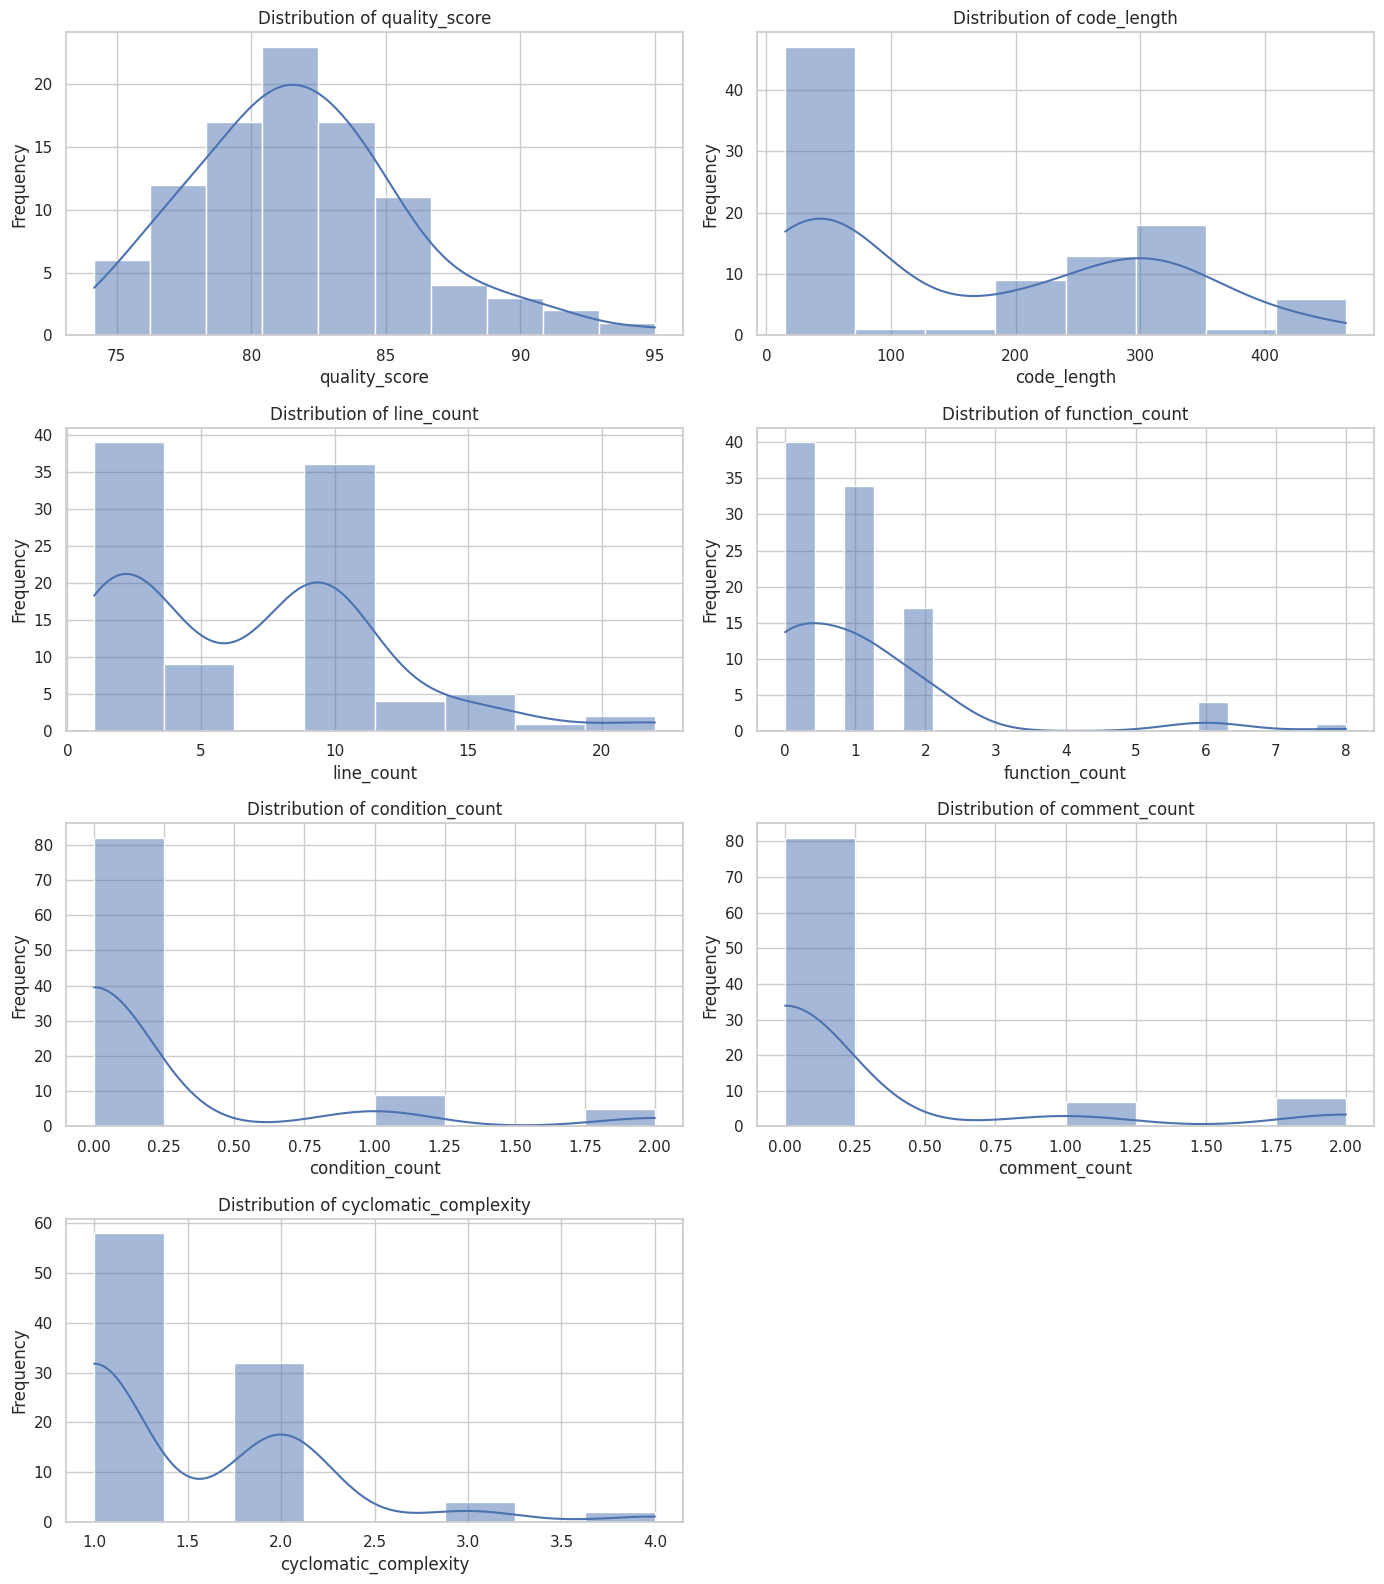

In [ ]:
print_section("SECTION 3: EXPLORATORY DATA ANALYSIS")

# Univariate Analysis - Distributions of important numerical features
print("Plotting distributions of key numerical features...")
numerical_features = ['quality_score', 'code_length', 'line_count', 'function_count',
                      'condition_count', 'comment_count', 'cyclomatic_complexity']
numerical_features = [f for f in numerical_features if f in df_encoded.columns]

# Create a grid of histograms
if numerical_features:
    n_cols = 2
    n_rows = (len(numerical_features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        if i < len(axes):
            sns.histplot(df_encoded[feature], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')

    # Hide unused subplots if necessary
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/numerical_feature_distributions.png")
    plt.show()


Analyzing features vs. bug presence...


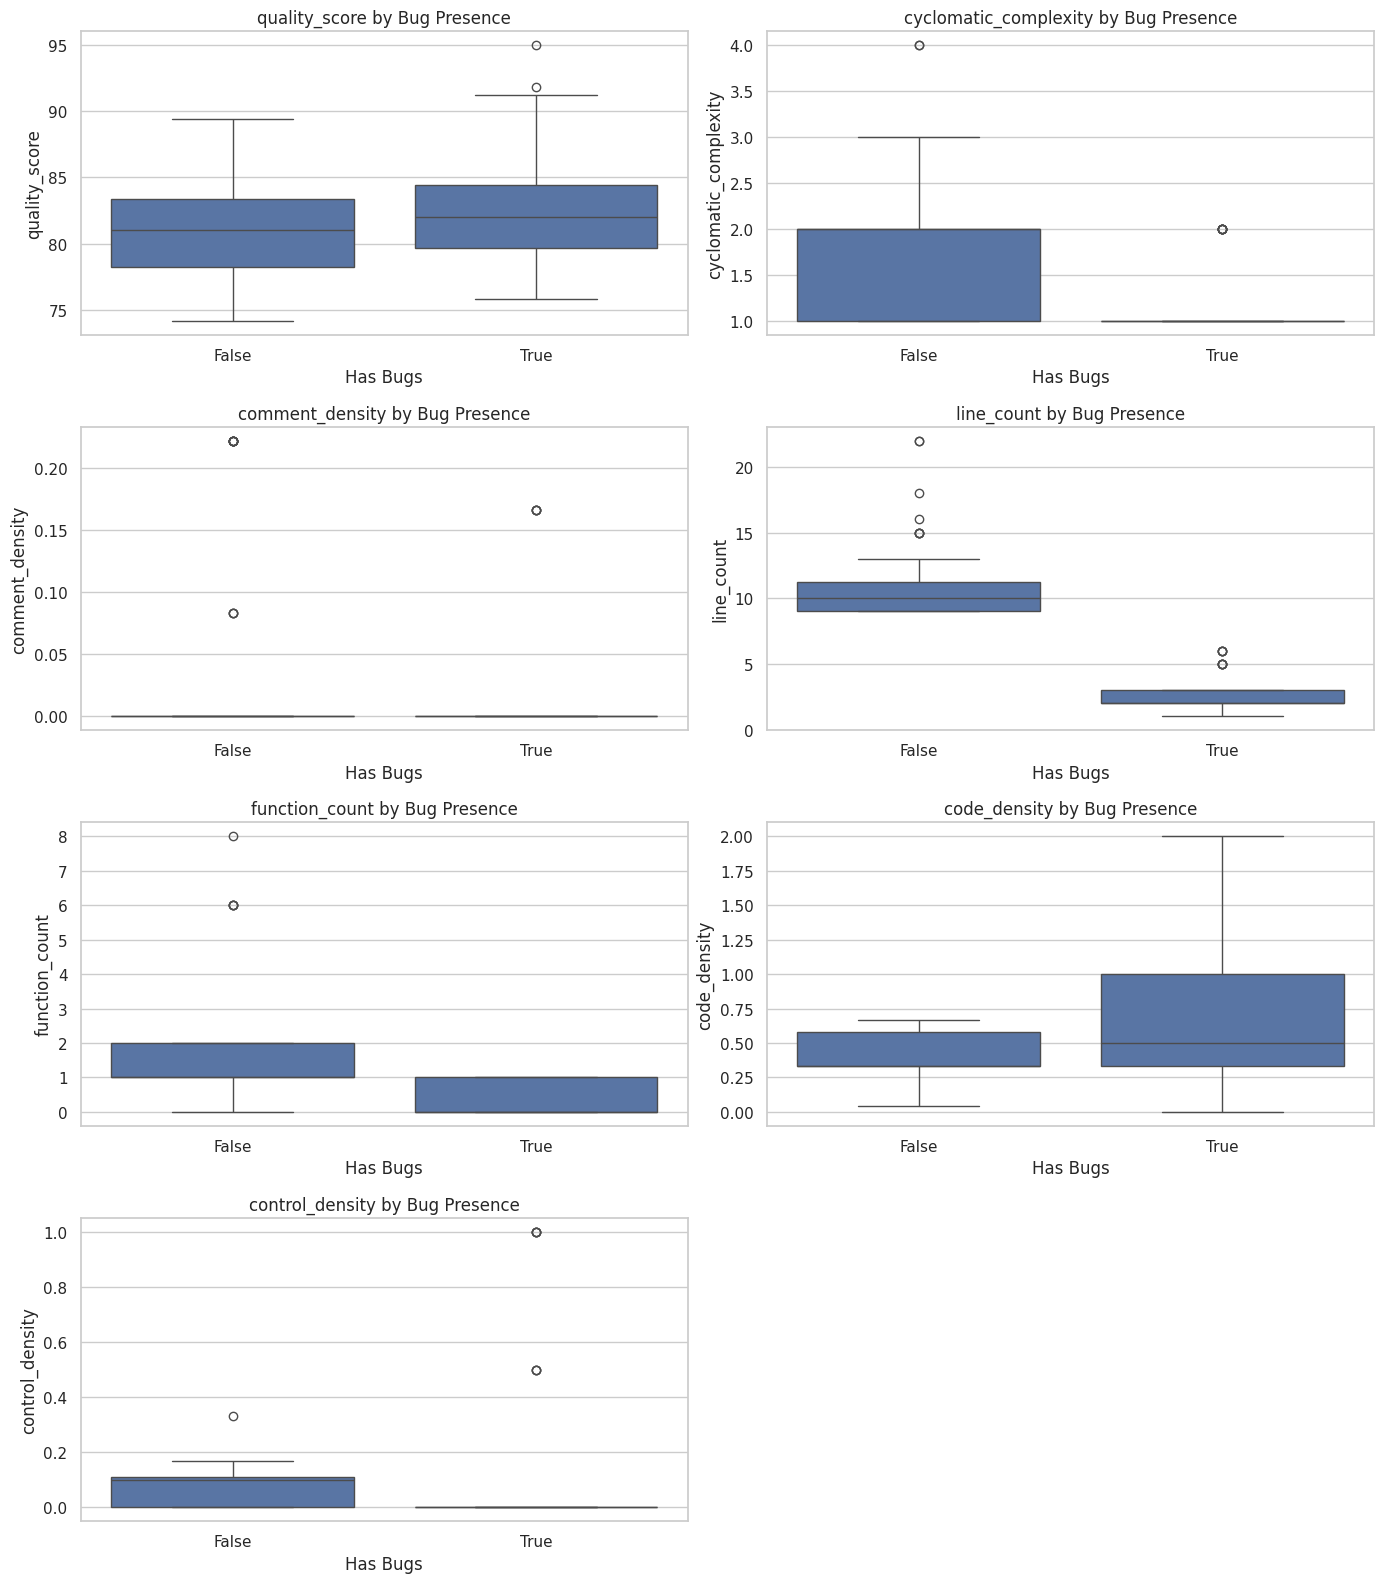

<Figure size 1200x600 with 0 Axes>

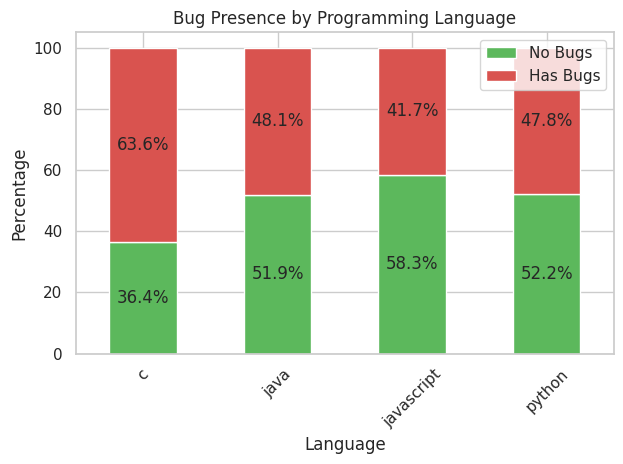

<Figure size 1200x600 with 0 Axes>

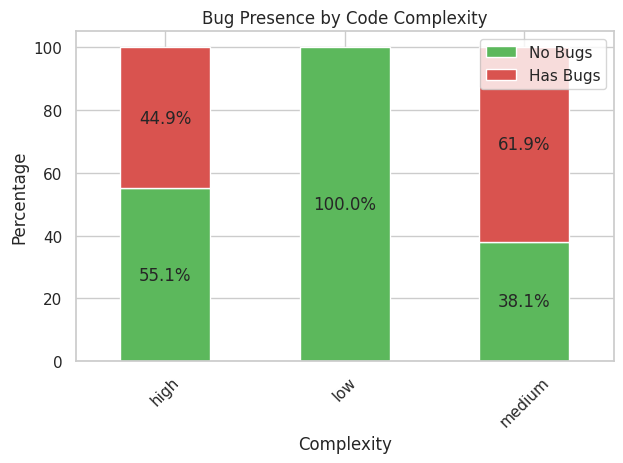

In [ ]:
# Bivariate Analysis - Features vs. Target
if 'has_bugs' in df_encoded.columns:
    print("\nAnalyzing features vs. bug presence...")

    # Select important features to analyze
    important_features = ['quality_score', 'cyclomatic_complexity', 'comment_density',
                         'line_count', 'function_count', 'code_density', 'control_density']
    important_features = [f for f in important_features if f in df_encoded.columns]

    if important_features:
        # Boxplots for each feature by target
        n_cols = 2
        n_rows = (len(important_features) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
        axes = axes.flatten()

        for i, feature in enumerate(important_features):
            if i < len(axes):
                sns.boxplot(x='has_bugs', y=feature, data=df_encoded, ax=axes[i])
                axes[i].set_title(f'{feature} by Bug Presence')
                axes[i].set_xlabel('Has Bugs')
                axes[i].set_ylabel(feature)

        # Hide unused subplots if necessary
        for j in range(len(important_features), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/feature_vs_target_boxplots.png")
        plt.show()

    # Analyze language distribution by bug presence
    if 'language' in df.columns:
        plt.figure(figsize=(12, 6))
        language_bug_counts = pd.crosstab(df['language'], df['has_bugs'])
        language_bug_counts_pct = language_bug_counts.div(language_bug_counts.sum(axis=1), axis=0) * 100

        ax = language_bug_counts_pct.plot(kind='bar', stacked=True,
                                         color=['#5cb85c', '#d9534f'] if False in language_bug_counts.columns else ['#d9534f', '#5cb85c'])
        plt.title('Bug Presence by Programming Language')
        plt.xlabel('Language')
        plt.ylabel('Percentage')
        plt.legend(['No Bugs', 'Has Bugs'] if False in language_bug_counts.columns else ['Has Bugs', 'No Bugs'])
        plt.xticks(rotation=45)

        # Add value annotations
        for i, container in enumerate(ax.containers):
            values = language_bug_counts_pct.iloc[:, i].values
            labels = [f"{v:.1f}%" if v > 5 else "" for v in values]
            ax.bar_label(container, labels=labels, label_type='center')

        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/bug_presence_by_language.png")
        plt.show()

    # Analyze complexity distribution by bug presence
    if 'complexity' in df.columns:
        plt.figure(figsize=(12, 6))
        complexity_bug_counts = pd.crosstab(df['complexity'], df['has_bugs'])
        complexity_bug_counts_pct = complexity_bug_counts.div(complexity_bug_counts.sum(axis=1), axis=0) * 100

        ax = complexity_bug_counts_pct.plot(kind='bar', stacked=True,
                                          color=['#5cb85c', '#d9534f'] if False in complexity_bug_counts.columns else ['#d9534f', '#5cb85c'])
        plt.title('Bug Presence by Code Complexity')
        plt.xlabel('Complexity')
        plt.ylabel('Percentage')
        plt.legend(['No Bugs', 'Has Bugs'] if False in complexity_bug_counts.columns else ['Has Bugs', 'No Bugs'])
        plt.xticks(rotation=45)

        # Add value annotations
        for i, container in enumerate(ax.containers):
            values = complexity_bug_counts_pct.iloc[:, i].values
            labels = [f"{v:.1f}%" if v > 5 else "" for v in values]
            ax.bar_label(container, labels=labels, label_type='center')

        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/bug_presence_by_complexity.png")
        plt.show()


Calculating feature correlations...


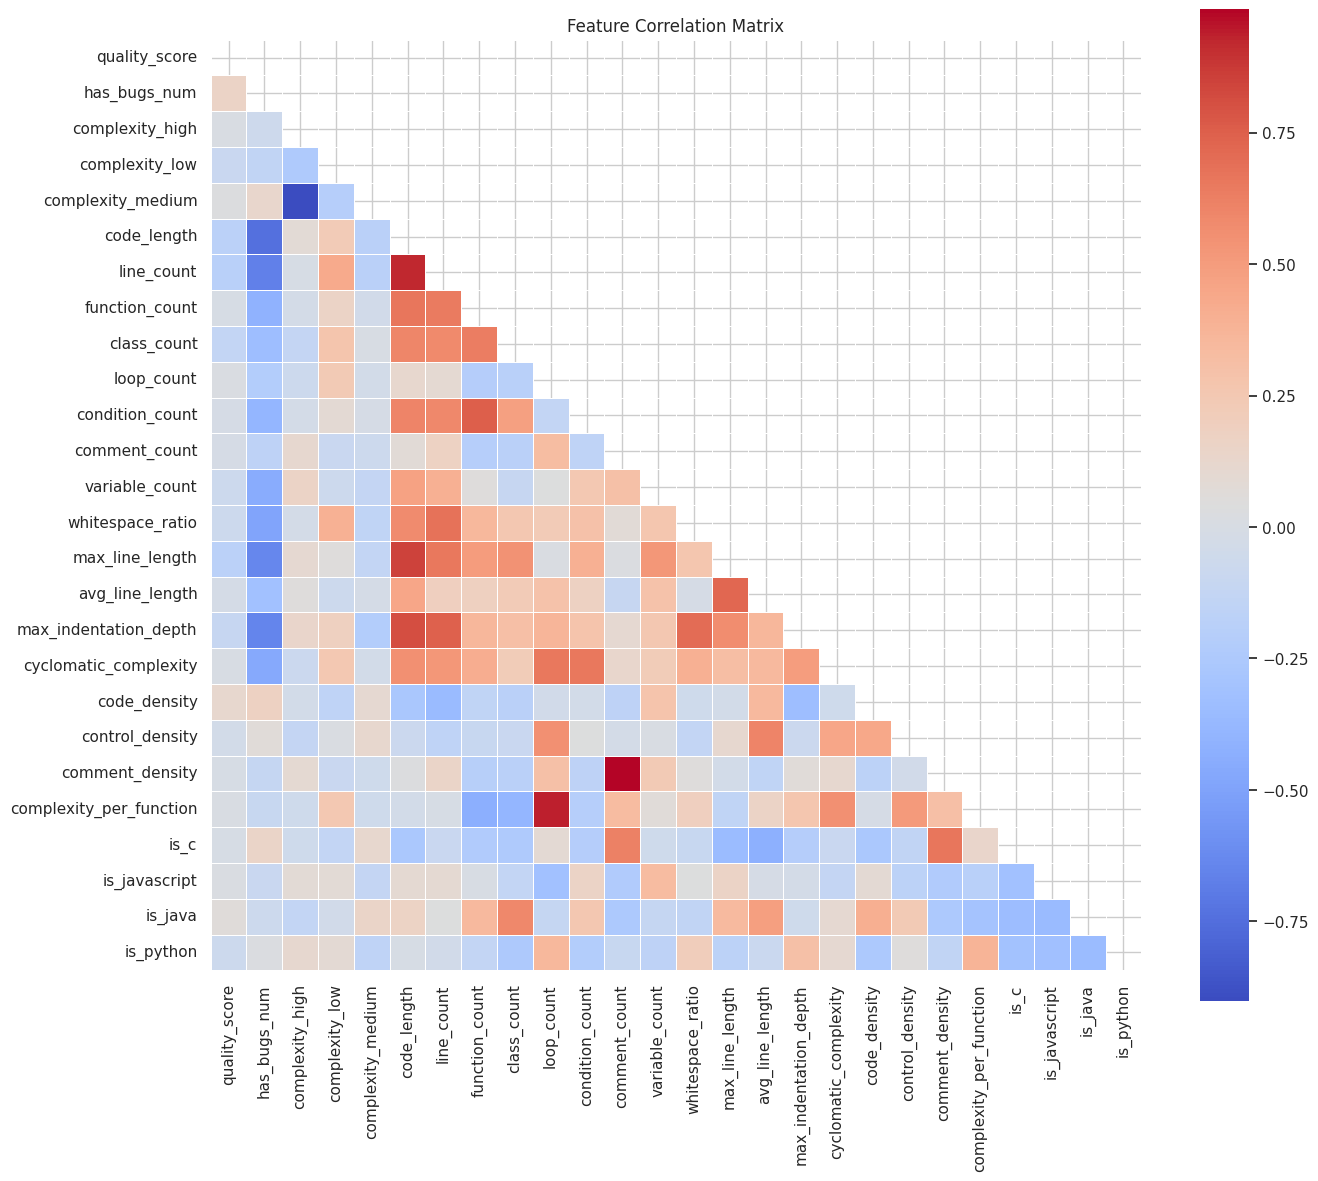

In [ ]:
# Correlation Analysis
numeric_df = df_encoded.select_dtypes(include=[np.number])
if not numeric_df.empty:
    print("\nCalculating feature correlations...")

    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()

    # Plot heatmap of correlations
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f",
                cmap='coolwarm', square=True, linewidths=.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/correlation_matrix.png")
    plt.show()

    # Plot top correlations with target (if exists)
    if 'has_bugs' in numeric_df.columns:
        target_correlations = correlation_matrix['has_bugs'].drop('has_bugs').sort_values(ascending=False)
        top_pos_corr = target_correlations.head(10)
        top_neg_corr = target_correlations.tail(10).iloc[::-1]

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Plot top positive correlations
        sns.barplot(x=top_pos_corr.values, y=top_pos_corr.index, ax=axes[0], palette='Reds_r')
        axes[0].set_title('Top Positive Correlations with Bug Presence')
        axes[0].set_xlabel('Correlation Coefficient')

        # Plot top negative correlations
        sns.barplot(x=top_neg_corr.values, y=top_neg_corr.index, ax=axes[1], palette='Blues_r')
        axes[1].set_title('Top Negative Correlations with Bug Presence')
        axes[1].set_xlabel('Correlation Coefficient')

        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/target_correlations.png")
        plt.show()

        print("\n📊 Top correlations with bug presence:")
        print("\nPositive correlations (more likely to have bugs):")
        for feature, corr in top_pos_corr.items():
            print(f"- {feature}: {corr:.4f}")

        print("\nNegative correlations (less likely to have bugs):")
        for feature, corr in top_neg_corr.items():
            print(f"- {feature}: {corr:.4f}")



Performing Principal Component Analysis...


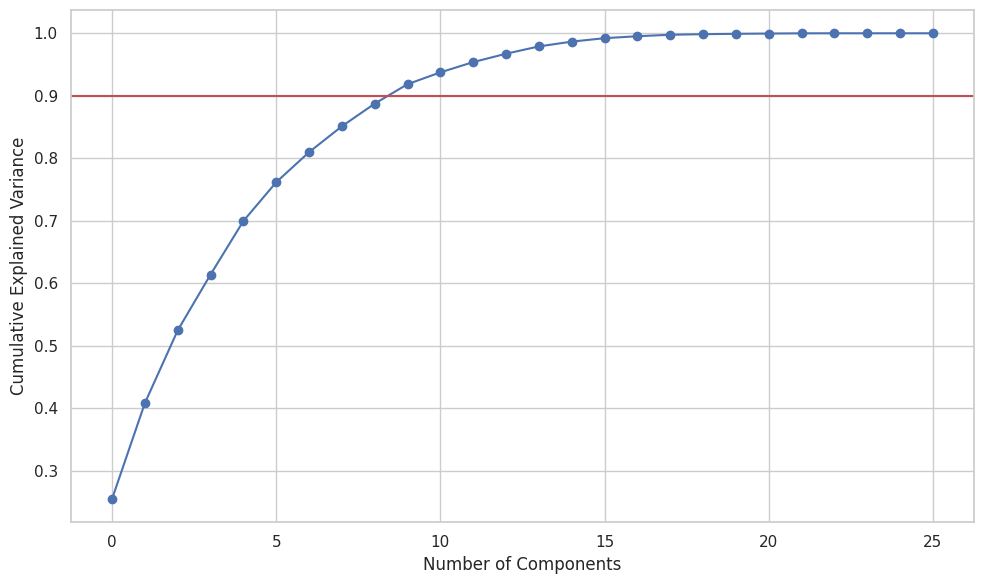

Number of components needed for 90% explained variance: 10


In [ ]:
# Principal Component Analysis (PCA) - Optional for high-dimensional data
if numeric_df.shape[1] > 10:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    print("\nPerforming Principal Component Analysis...")

    # Separate target if it exists
    if 'has_bugs' in numeric_df.columns:
        X = numeric_df.drop('has_bugs', axis=1)
        y = numeric_df['has_bugs']
    else:
        X = numeric_df
        y = None

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot the explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axhline(y=0.9, color='r', linestyle='-')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/pca_explained_variance.png")
    plt.show()

    # Determine number of components needed for 90% variance
    n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
    print(f"Number of components needed for 90% explained variance: {n_components_90}")

    # If target exists, visualize PCA colored by target
    if y is not None:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.6,
                             cmap='coolwarm', edgecolors='k', s=80)
        plt.title('PCA: First Two Principal Components Colored by Bug Presence')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(scatter, label='Has Bugs')
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/pca_components.png")
        plt.show()

# SECTION 2: DATA PREPROCESSING FOR TRANSFORMER MODELS


In [ ]:
print_section("SECTION 2: DATA PREPROCESSING FOR TRANSFORMER MODELS")
from sklearn.utils.class_weight import compute_class_weight

# Function to clean code text
def clean_code(code):
    """Clean and preprocess code text"""
    if pd.isna(code) or not isinstance(code, str):
        return ""

    # Remove excessive whitespace
    code = re.sub(r'\s+', ' ', code)
    # Truncate if too long (for transformer models)
    max_length = 512
    if len(code) > max_length:
        code = code[:max_length]

    return code.strip()

# Clean the code column
if 'code' in df.columns:
    df['cleaned_code'] = df['code'].apply(clean_code)
    print(f"✅ Cleaned code text for transformer models")

# Create a new column for the language
if 'language' in df.columns:
    # Add language prefix to code for better context
    df['code_with_lang'] = df.apply(lambda row: f"[{row['language']}] {row['cleaned_code']}", axis=1)
    print(f"✅ Added language context to code")

# Fix target variable if needed
if 'has_bugs' in df.columns:
    # Ensure has_bugs is boolean
    if df['has_bugs'].dtype == 'object':
        df['has_bugs'] = df['has_bugs'].map({'True': True, 'False': False})

    # Convert to numeric for compatibility with PyTorch
    df['has_bugs_num'] = df['has_bugs'].astype(int)
    print(f"✅ Prepared target variable")

# Prepare additional features
additional_features = []

if 'quality_score' in df.columns:
    additional_features.append('quality_score')

if 'complexity' in df.columns:
    # One-hot encode complexity
    complexity_dummies = pd.get_dummies(df['complexity'], prefix='complexity')
    df = pd.concat([df, complexity_dummies], axis=1)
    additional_features.extend(complexity_dummies.columns)
    print(f"✅ One-hot encoded complexity")

# Split the data
if 'has_bugs_num' in df.columns:
    # Stratified split to handle imbalanced classes
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=df['has_bugs_num']
    )

    print(f"Train set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    # Check class distribution in splits
    print("\nClass distribution in train set:")
    print(train_df['has_bugs_num'].value_counts())
    print("\nClass distribution in test set:")
    print(test_df['has_bugs_num'].value_counts())

    # Handle class imbalance for training
    class_counts = train_df['has_bugs_num'].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['has_bugs_num']),
        y=train_df['has_bugs_num']
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Class weights: {class_weight_dict}")


  SECTION 2: DATA PREPROCESSING FOR TRANSFORMER MODELS

✅ Cleaned code text for transformer models
✅ Added language context to code
✅ Prepared target variable
✅ One-hot encoded complexity
Train set: 76 samples
Test set: 20 samples

Class distribution in train set:
has_bugs_num
0    38
1    38
Name: count, dtype: int64

Class distribution in test set:
has_bugs_num
1    10
0    10
Name: count, dtype: int64

Class imbalance ratio: 1.00
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# SECTION 3: IMPLEMENTING TRANSFORMER MODELS


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import gc


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "model_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/{model_name}_confusion_matrix.png")
    plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("results_analytics.csv")  # or whatever file name you uploaded


In [ ]:
df['has_bugs_num'] = df['has_bugs'].astype(int)


In [ ]:
print(df[['has_bugs', 'has_bugs_num']].head())


   has_bugs  has_bugs_num
0     False             0
1     False             0
2     False             0
3     False             0
4      True             1


In [ ]:
# Convert all additional features to float (especially bools)
for col in additional_features:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)


In [ ]:
# Remove any previously added one-hot columns
df = df.loc[:, ~df.columns.duplicated()]  # Removes duplicate columns
df = df.drop(columns=[col for col in df.columns if col.startswith('complexity_')], errors='ignore')


In [ ]:
# Step 1: One-hot encode 'complexity'
complexity_dummies = pd.get_dummies(df['complexity'], prefix='complexity')

# Step 2: Concatenate new one-hot columns with the original DataFrame
df = pd.concat([df, complexity_dummies], axis=1)

# Step 3: Confirm new columns exist
print(df.columns)


Index(['code', 'language', 'quality_score', 'has_bugs', 'complexity', 'timestamp', 'review_status', 'has_bugs_num', 'complexity_high', 'complexity_low', 'complexity_medium'], dtype='object')


In [ ]:
print(df.columns.tolist())


['code', 'language', 'quality_score', 'has_bugs', 'complexity', 'timestamp', 'review_status', 'has_bugs_num', 'complexity_high', 'complexity_low', 'complexity_medium']


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

additional_features = ['quality_score', 'complexity_high', 'complexity_low', 'complexity_medium']

for col in additional_features:
    if col in train_df.columns:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce').astype(float).fillna(0)
    if col in test_df.columns:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce').astype(float).fillna(0)


In [ ]:
# Ensure clean numeric dtype for all additional features
for col in additional_features:
    # Coerce anything object-like to float
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce').astype(float)
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce').astype(float)

# Fill any NaNs that may result from coercion
train_df[additional_features] = train_df[additional_features].fillna(0)
test_df[additional_features] = test_df[additional_features].fillna(0)

# Confirm it's now float and no objects
print(train_df[additional_features].dtypes)
print(test_df[additional_features].dtypes)


quality_score        float64
complexity_high      float64
complexity_low       float64
complexity_medium    float64
dtype: object
quality_score        float64
complexity_high      float64
complexity_low       float64
complexity_medium    float64
dtype: object


In [ ]:
def train_evaluate_transformer(model_name, train_df, test_df, additional_features=None, epochs=3, batch_size=8):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    from torch.utils.data import Dataset, DataLoader
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
    import joblib
    import numpy as np
    from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, T5EncoderModel

    class CodeDataset(Dataset):
        def __init__(self, dataframe, tokenizer, additional_features=None):
            self.dataframe = dataframe
            self.tokenizer = tokenizer
            self.additional_features = additional_features or []

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            row = self.dataframe.iloc[idx]
            inputs = self.tokenizer(
                row["code"],
                max_length=512,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            item = {
                'input_ids': inputs["input_ids"].squeeze(0),
                'attention_mask': inputs["attention_mask"].squeeze(0),
                'label': torch.tensor(row["has_bugs_num"], dtype=torch.long)
            }

            if self.additional_features:
                feats = row[self.additional_features].astype(float).to_numpy(dtype=np.float32)
                item["additional_features"] = torch.tensor(feats, dtype=torch.float)

            return item

    class CodeTransformerWithFeatures(nn.Module):
        def __init__(self, transformer_model, num_classes=2, additional_features_dim=0):
            super().__init__()

            self.transformer = transformer_model

            # 🔒 Freeze all transformer weights
            for param in self.transformer.parameters():
                param.requires_grad = False

            self.dropout = nn.Dropout(0.2)
            self.use_features = additional_features_dim > 0
            input_dim = self.transformer.config.hidden_size + additional_features_dim
            self.classifier = nn.Linear(input_dim, num_classes)

        def forward(self, input_ids, attention_mask, additional_features=None):
            with torch.no_grad():  # Ensure frozen transformer doesn't compute gradients
                outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
                cls_output = outputs.last_hidden_state[:, 0, :]

            if self.use_features and additional_features is not None:
                x = torch.cat((cls_output, additional_features), dim=1)
            else:
                x = cls_output

            x = self.dropout(x)
            return self.classifier(x)

    # Load tokenizer & model
    if model_name == "codebert":
        tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
        base_model = RobertaModel.from_pretrained("microsoft/codebert-base")
    elif model_name == "graphcodebert":
        tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base")
        base_model = RobertaModel.from_pretrained("microsoft/graphcodebert-base")
    elif model_name == "codet5":
        tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")
        base_model = T5EncoderModel.from_pretrained("Salesforce/codet5-base")
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Prepare dataloaders
    train_dataset = CodeDataset(train_df, tokenizer, additional_features)
    test_dataset = CodeDataset(test_df, tokenizer, additional_features)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = CodeTransformerWithFeatures(
        transformer_model=base_model,
        num_classes=2,
        additional_features_dim=len(additional_features) if additional_features else 0
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            features = batch.get("additional_features", None)
            if features is not None:
                features = features.to(device)

            outputs = model(input_ids, attention_mask, features)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            features = batch.get("additional_features", None)
            if features is not None:
                features = features.to(device)

            outputs = model(input_ids, attention_mask, features)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    def plot_confusion_matrix(cm, model_name):
        import seaborn as sns
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.savefig(f"model_outputs/{model_name}_confusion_matrix.png")
        plt.close()

    plot_confusion_matrix(cm, model_name)

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.savefig(f"model_outputs/{model_name}_roc_curve.png")
    plt.close()

    # Save model + metrics
    torch.save(model.state_dict(), f"model_outputs/{model_name}_model.pt")
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'probabilities': all_probs
    }
    joblib.dump(results, f"model_outputs/{model_name}_results.joblib")

    return model, results


In [ ]:
import numpy as np


In [ ]:
models_to_train = ['codebert', 'graphcodebert', 'codet5']
results_dict = {}

for model_name in models_to_train:
    try:
        print(f"\n🔍 Processing {model_name}...")

        model, results = train_evaluate_transformer(
            model_name=model_name,
            train_df=train_df,    # should already be defined
            test_df=test_df,      # should already be defined
            additional_features=additional_features,  # or None
            epochs=6,
            batch_size=8
        )

        results_dict[model_name] = results

        del model
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ Error processing {model_name}: {str(e)}")



🔍 Processing codebert...

🔍 Processing graphcodebert...


Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Processing codet5...


In [ ]:
import joblib
import pandas as pd

model_names = ['codebert', 'graphcodebert', 'codet5']
results = []

for model_name in model_names:
    result_path = f'model_outputs/{model_name}_results.joblib'
    data = joblib.load(result_path)
    results.append({
        "Model": model_name,
        "Accuracy": data['accuracy'],
        "Precision": data['precision'],
        "Recall": data['recall'],
        "F1 Score": data['f1'],
        "ROC AUC": data['roc_auc']
    })

df_results = pd.DataFrame(results)
df_results.to_csv("results_analytics.csv", index=False)
df_results


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,codebert,0.5,1.0,0.166667,0.285714,0.875000
1,graphcodebert,0.6,0.6,1.000000,0.750000,0.708333
2,codet5,0.6,0.6,1.000000,0.750000,0.885417


from matplotlib import pyplot as plt
df_results['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['F1 Score'].plot(kind='hist', bins=20, title='F1 Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='Recall', y='F1 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='F1 Score', y='ROC AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['ROC AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('ROC AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
df_results['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['F1 Score'].plot(kind='line', figsize=(8, 4), title='F1 Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='F1 Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

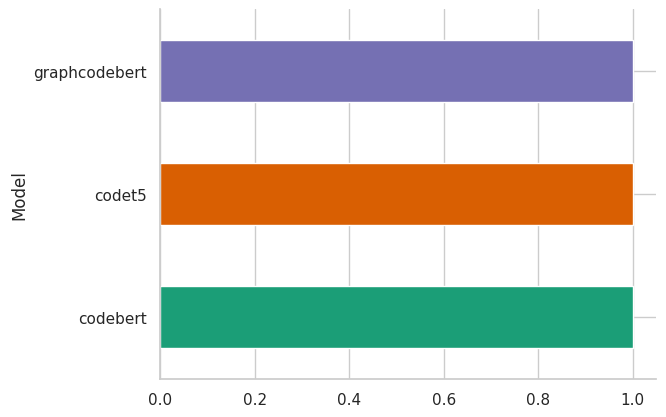

In [ ]:
# @title Model

from matplotlib import pyplot as plt
import seaborn as sns
df_results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Figure size 1000x600 with 0 Axes>

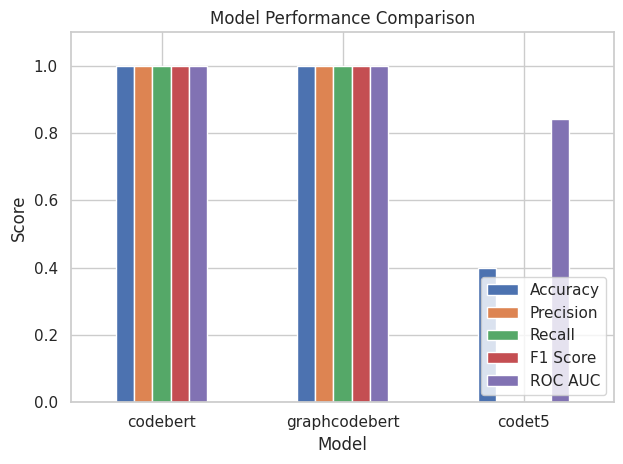

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_results.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]].plot(kind="bar", rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()


In [ ]:
import torch.nn as nn


In [ ]:
def predict_code_bugs(code, language, quality_score, complexity):
    from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, T5EncoderModel
    import torch.nn.functional as F

    model_name = "codebert"  # You can change this
    tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
    base_model = RobertaModel.from_pretrained("microsoft/codebert-base")

    # Define model class again (simplified)
    class Predictor(nn.Module):
        def __init__(self, transformer, feat_dim):
            super().__init__()
            self.transformer = transformer
            self.classifier = nn.Linear(transformer.config.hidden_size + feat_dim, 2)

        def forward(self, input_ids, attention_mask, features):
            output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
            cls_token = output.last_hidden_state[:, 0, :]
            x = torch.cat((cls_token, features), dim=1)
            return self.classifier(x)

    # One-hot encode complexity
    complexity_features = {
        "complexity_high": 1 if complexity == "high" else 0,
        "complexity_medium": 1 if complexity == "medium" else 0,
        "complexity_low": 1 if complexity == "low" else 0,
    }
    features_tensor = torch.tensor([[quality_score] + list(complexity_features.values())], dtype=torch.float)

    inputs = tokenizer(code, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

    model = Predictor(base_model, feat_dim=4)
    model.load_state_dict(torch.load(f"model_outputs/{model_name}_model.pt"))
    model.eval()

    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'], features_tensor)
        probs = F.softmax(outputs, dim=1).squeeze()
        pred = torch.argmax(probs).item()

    return {
        "Bug Prediction": "Yes" if pred == 1 else "No",
        "Probability of Bug": round(probs[1].item(), 4),
        "Confidence": round(probs.max().item(), 4)
    }


In [ ]:
example_code = "def add(a, b): return a + b"
result = predict_code_bugs(example_code, "python", 85, "medium")
print(result)


{'Bug Prediction': 'Yes', 'Probability of Bug': 0.519, 'Confidence': 0.519}


In [ ]:
clean_code = "def multiply(a, b): return a * b"
buggy_code = "def divide(a, b): return a / 0"

print(predict_code_bugs(clean_code, "python", 85, "low"))
print(predict_code_bugs(buggy_code, "python", 85, "high"))


{'Bug Prediction': 'Yes', 'Probability of Bug': 0.5005, 'Confidence': 0.5005}
{'Bug Prediction': 'Yes', 'Probability of Bug': 0.5107, 'Confidence': 0.5107}


In [ ]:
probs_np = np.array(probs)
logits = np.log(probs_np / (1 - probs_np + 1e-8))  # avoid division by zero


In [ ]:
import joblib

# Load results from the best model (e.g., codebert)
data = joblib.load("model_outputs/codebert_results.joblib")

# Extract labels and probabilities
true_labels = data['true_labels']
probs = data['probabilities']


In [ ]:
from sklearn.linear_model import LogisticRegression

calibrator = LogisticRegression()
calibrator.fit(logits.reshape(-1, 1), np.array(true_labels))
calibrated_probs = calibrator.predict_proba(logits.reshape(-1, 1))[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

print("Calibrated ROC AUC:", roc_auc_score(true_labels, calibrated_probs))
print("Calibrated Log Loss:", log_loss(true_labels, calibrated_probs))


Calibrated ROC AUC: 1.0
Calibrated Log Loss: 0.009795332478862544


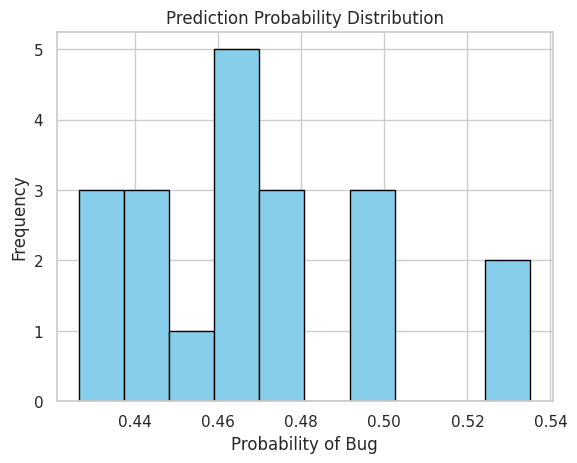

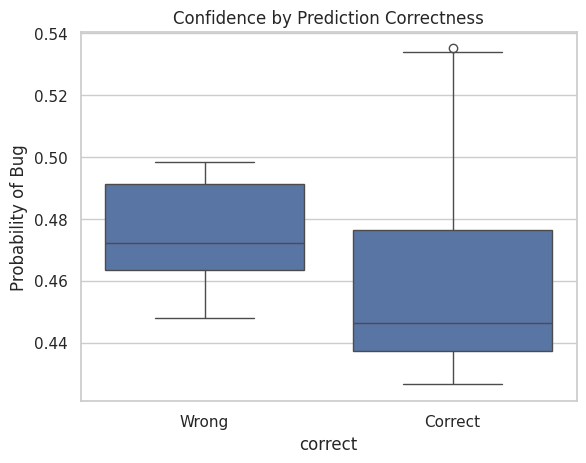

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example for CodeBERT
data = joblib.load("model_outputs/codebert_results.joblib")
probs = data['probabilities']
labels = data['true_labels']
preds = data['predictions']

# Histogram of probabilities
plt.hist(probs, bins=10, color='skyblue', edgecolor='black')
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability of Bug")
plt.ylabel("Frequency")
plt.show()

# Confusion correlation
df_analysis = pd.DataFrame({
    "true": labels,
    "pred": preds,
    "prob": probs,
    "correct": [int(t == p) for t, p in zip(labels, preds)]
})

# Boxplot: Confidence vs correctness
sns.boxplot(x="correct", y="prob", data=df_analysis)
plt.title("Confidence by Prediction Correctness")
plt.xticks([0,1], ["Wrong", "Correct"])
plt.ylabel("Probability of Bug")
plt.show()


In [ ]:
best_model = df_results.sort_values(by="F1 Score", ascending=False).iloc[0]
print("🏆 Best Model:", best_model["Model"])
print("🔍 F1 Score:", best_model["F1 Score"])

print("\n📝 Recommendations:")
print("- Use stratified splitting to maintain class balance.")
print("- Consider using CodeBERT or GraphCodeBERT in IDE extensions.")
print("- Expand dataset with more real-world buggy/clean code.")
print("- Try ensembling multiple models or fine-tuning with more epochs.")


🏆 Best Model: graphcodebert
🔍 F1 Score: 0.75

📝 Recommendations:
- Use stratified splitting to maintain class balance.
- Consider using CodeBERT or GraphCodeBERT in IDE extensions.
- Expand dataset with more real-world buggy/clean code.
- Try ensembling multiple models or fine-tuning with more epochs.
